# PPO

In [ ]:
'''
highway
'''

import os
import sys
import random
import gymnasium as gym
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils.highway_utils import train_PPO_agent, compute_advantage, read_ckp
from utils.cvae import CVAE, cvae_train
# from dynamic_model.train_Ensemble_dynamic_model import *
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import argparse
import warnings
warnings.filterwarnings('ignore')

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.h_1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.h_1(F.relu(self.fc1(x))))
        return F.softmax(self.fc2(x), dim=-1)
    
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.h_1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.h_1(F.relu(self.fc1(x))))
        return self.fc2(x)


class PPO:
    def __init__(
        self,
        state_dim: int,
        hidden_dim: int,
        action_dim: int,
        cvae: object=None,
        actor_lr: float=1e-4,
        critic_lr: float=5e-3,
        gamma: float=0.9,
        lmbda: float=0.9,
        epochs: int=20,
        eps: float=0.2,
        device: str='cpu',
    ):
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma  # 时序差分学习率
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device
        if cvae:
            self.cvae = cvae.to(device)
            self.cvae_optimizer = torch.optim.Adam(self.cvae.parameters(), lr=1e-3)
        else:
            self.cvae = None

    def take_action(self, state) -> list:
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(np.array(transition_dict['truncated']), dtype=torch.int).view(-1, 1).to(self.device)
        
        # * 技巧
        # self.train_cvae(states, next_states)  # 训练 vae, 如果是已经预训练好的就无需训练
        # self.cvae_generate(32)  # 生成 cvae 图像观察效果
        if self.cvae:
            pre_next_state = self.predict_next_state(states, next_states)
            target_q1 = self.critic(pre_next_state).detach()
            target_q2 = self.critic(next_states).detach()
            target_q = torch.min(target_q1, target_q2)
        else:
            target_q = self.critic(next_states).detach()
            
        td_target = rewards + self.gamma * target_q * (1 - dones | truncated)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        # 所谓的另一个演员就是原来的演员的初始状态
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs)  # 重要性采样系数
            surr1 = ratio * advantage  # 重要性采样
            surr2 = torch.clip(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            
    def train_cvae(self, state, next_state):
        vae_action = next_state[:, :4]
        diff_state = next_state[:, 5:] - state[:, 5:]
        train_loss = cvae_train(self.cvae, diff_state, vae_action, self.cvae_optimizer)
        return train_loss
    
    def predict_next_state(self, state, next_state):
        action = state[:, :4]
        with torch.no_grad():
            sample = torch.randn(state.shape[0], 32).to(device)  # 随机采样的
            generated = self.cvae.decode(sample, action)
        pre_next_state = torch.concat([next_state[:, :5], state[:, 5:] + generated], dim=-1)
        return pre_next_state
    
    
# * --------------------- 参数 -------------------------
# 环境相关
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env = gym.make('highway-v0', render_mode='human')
seed = 42
# env = gym.make("highway-v0", render_mode='rgb_array')


# PPO相关
actor_lr = 5e-4
critic_lr = 1e-3
lmbda = 0.95  # 似乎可以去掉，这一项仅用于调整计算优势advantage时，额外调整折算奖励的系数
gamma = 0.98  # 时序差分学习率，也作为折算奖励的系数之一
total_epochs = 1  # 迭代轮数
eps = 0.2  # 截断范围参数, 1-eps ~ 1+eps
epochs = 10  # PPO中一条序列训练多少轮，和迭代算法无关

# 神经网络相关
hidden_dim = 64
state_dim = torch.multiply(*env.observation_space.shape)
action_dim = env.action_space.n

# VAE
# cvae = CVAE(32, action_dim, 32)  # 在线训练
# 需要预训练
# cvae = torch.load(f'model/cvae/{args.cvae_kind}.pt', map_location=device) if args.cvae_kind else None  

# 任务相关
system_type = sys.platform  # 操作系统
print('device:', device)

# * ----------------------- 训练 ----------------------------
CKP_PATH = f'ckpt/highway/PPO/{seed}/{system_type}.pt'
# env = gym.make("highway-v0", render_mode='rgb_array')
agent = PPO(state_dim, hidden_dim, action_dim, None, actor_lr, 
            critic_lr, gamma, lmbda, epochs, eps, device)
s_epoch, s_episode, return_list, time_list, seed_list = read_ckp(CKP_PATH, agent, 'PPO')

obs, info = env.reset()
done = truncated = False
total_reward = 0
while not (done | truncated):
    obs = obs.reshape(-1)
    action = agent.take_action(obs)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward

print(round(total_reward, 3))
env.close()

In [ ]:
env.close()

# DQN

In [9]:
import os
import sys
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
from utils.highway_utils import read_ckp, train_DQN
from utils.cvae import CVAE, cvae_train
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import argparse
import warnings
warnings.filterwarnings('ignore')

class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.h_1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.h_1(F.relu(self.fc1(x)))))
        V = self.fc_V(F.relu(self.h_1(F.relu(self.fc1(x)))))
        Q = V + A - A.mean(-1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q
    
class DQN:
    ''' DQN算法,包括Double DQN '''
    
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate,
                 gamma, epsilon, update_interval, sta, device,):
        
        self.action_dim = action_dim
        self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.update_interval = update_interval
        self.sta = sta
        # self.sta = sta_kind
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(state, dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'], dtype=torch.int).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
        
        # * 技巧一
        if self.sta and self.sta.quality > 0.3:
            pre_next_state = self.predict_next_state(states, next_states)
            target_q1 = self.target_q_net(pre_next_state).detach()
            target_q2 = self.target_q_net(next_states).detach()
            max_next_q_values = torch.min(target_q1, target_q2)
        else:
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
            
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones | truncated)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step() # 执行Adam梯度下降

        if self.count % self.update_interval == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1
    
    def train_cvae(self, state, next_state, test_and_feedback, batch_size):
        vae_action = next_state[:, :4]
        diff_state = next_state[:, 5:] - state[:, 5:]
        loss = cvae_train(self.sta, self.device, diff_state, vae_action, self.sta_optimizer, test_and_feedback, batch_size)
        return loss
    
    def predict_next_state(self, state, next_state):
        action = state[:, :4]
        with torch.no_grad():
            sample = torch.randn(state.shape[0], 32).to(device)  # 随机采样的
            generated = self.sta.decode(sample, action)
        pre_next_state = torch.concat([next_state[:, :5], state[:, 5:] + generated], dim=-1)
        return pre_next_state

    
# * --------------------- 参数 -------------------------
# 环境相关
env = gym.make("highway-v0", render_mode='rgb_array')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
mission = 'highway'
model_name = 'DQN~cvae'
system_type = 'linux'  # sys.platform  # 操作系统
seed = 43

# DQN相关
total_epoch = 1  # 迭代数, 无需多次迭代
gamma = 0.98
epsilon = 1  # 刚开始随机动作,更新中线性降低
update_interval = 50  # 若干回合更新一次目标网络
minimal_size = 500  # 最小经验数
batch_size = 128
buffer_size = 20000

# 神经网络相关
lr = 2e-3
state_dim = torch.multiply(*env.observation_space.shape)
hidden_dim = 256
action_dim = env.action_space.n

# * ----------------------- 训练 ----------------------------
CKP_PATH = f'ckpt/highway/{model_name}/{seed}/{system_type}.pt'
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, update_interval, None, device)
s_epoch, s_episode, return_list, time_list, seed_list, replay_buffer = read_ckp(CKP_PATH, agent, model_name, 20000)
agent.epsilon = 0
env.close()

[ checkpoint ] 读取已有模型权重和训练数据...


In [21]:
ACTIONS_ALL = {
        0: '左转',
        1: '匀速',
        2: '右转',
        3: '加速',
        4: '减速'
    }

env = gym.make("highway-v0", render_mode='human')
env.configure({
    "lanes_count": 4,
    "vehicles_density": 1.5,
    "duration": 100,
    # "collision_reward": -30,
    # "right_lane_reward": 0.2,
    # "high_speed_reward": 0,
    # "offroad_terminal": False,
    # "reward_speed_range": [20, 30],
    # "manual_control": True
})

'''
env.configure({
    "lanes_count": 3,
    "vehicles_density": 1.5,
    "duration": 100,
    "collision_reward": -30,
    "right_lane_reward": 0.2,
    "high_speed_reward": 2,
    "offroad_terminal": False,
    # "reward_speed_range": [20, 30],
    "action": {
        "type": "DiscreteMetaAction",
        "longitudinal": True,
        "lateral": True,
        "target_speeds": [17, 23, 30],  # TODO 调整速度
    },
    # "manual_control": True
})'''

obs, info = env.reset()
done = truncated = False
total_reward = 0
while not (done | truncated):
    obs = obs.reshape(-1)
    action = agent.take_action(obs)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    print(ACTIONS_ALL[action], end='\r')
    
print(round(total_reward, 3))
env.close()

16.735


In [ ]:
env.close()

# RDQN

In [1]:
from utils.RDQN_modules import *
import torch
env = gym.make("highway-v0", render_mode='human')
agent = DQNAgent(env, 0, 128, 0, 42, n_step=1)

cuda


In [2]:
checkpoint = torch.load('ckpt/highway/RDQN_Normal/42/linux.pt')
agent.dqn.load_state_dict(checkpoint["best_weight"])

<All keys matched successfully>

In [6]:
env.configure({
    "lanes_count": 4,
    "vehicles_density": 1.5,
    "duration": 100,
    # "collision_reward": -30,
    # "right_lane_reward": 0.2,
    # "high_speed_reward": 0,
    # "offroad_terminal": False,
    # "reward_speed_range": [20, 30],
    # "manual_control": True
})

obs, info = env.reset()
done = truncated = False
total_reward = 0
while not (done | truncated):
    obs = obs.reshape(-1)
    action = agent.select_action(obs)
    obs, reward, done, truncated, info = env.step(action)
    total_reward += reward
    
print(round(total_reward, 3))
env.close()

12.294


# Train CVAE

In [10]:
import torch
from utils.RDQN_modules import *
from tqdm import trange

In [4]:
buffer = torch.load('ckpt/CartPole-v1/RDQN_Normal/42/win32.pt')['replay_buffer']

In [32]:
state = buffer.obs_buf
next_state = buffer.next_obs_buf
action = torch.tensor(buffer.acts_buf).unsqueeze(-1)

In [33]:
diff_state = next_state - state

In [34]:
diff_state

array([[-7.6853214e-03,  1.9481656e-01,  6.7697391e-03, -2.8597903e-01],
       [-3.7889909e-03,  1.9471259e-01,  1.0501593e-03, -2.8378519e-01],
       [ 1.0526180e-04, -1.9552201e-01, -4.6255458e-03,  3.0164051e-01],
       ...,
       [-2.2002496e-05, -1.9592384e-01, -1.8202960e-03,  3.1088713e-01],
       [-3.9404794e-03,  1.9424982e-01,  4.3974482e-03, -2.7389818e-01],
       [-5.5482145e-05, -1.9595633e-01, -1.0805167e-03,  3.1164593e-01]],
      dtype=float32)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = diff_state.shape[-1]
condition_dim = 1
latent_dim = input_dim
batch_size = 16

fig_path = f'image/VAE/regular/{batch_size}/'

# 训练
model = CVAE(input_dim, condition_dim, latent_dim).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
quality = []
for epoch in trange(num_epochs, ncols=70):
    cvae_train(model, device, diff_state, action, optimizer, False, batch_size)
    quality.append(model.generate_test(32, 4, epoch, fig_path))
print(f'\n==> Generate silhouette score: {[round(i, 3) for i in quality]}')
plt.figure()
sns.lineplot(quality)
plt.xlabel('Epoch')
plt.ylabel('Silhouette score')
plt.grid()
plt.savefig(f'{fig_path}/Silhouette score.png')
plt.close()
torch.save(model, f'model/cvae/CartPole-v1/regular.pt')
print(model.quality)

# 经验分布情况

In [26]:
import torch
from utils.RDQN_modules import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 15

In [44]:
buffer = torch.load('ckpt/sumo/CEA/42_linux.pt')['replay_buffer']

In [45]:
exp_type = buffer.exp_type_buf

In [46]:
buffer.size

20000

In [47]:
def check_priorities(buffer):
    """Check and print the priority of each experience."""
    priority = []
    for idx in range(len(buffer)):
        # 获取存储的优先级的alpha次方
        stored_priority_alpha = buffer.sum_tree[idx]
        # 还原原始优先级值，如果你知道alpha的值的话
        original_priority = stored_priority_alpha**(1/buffer.alpha)
        # print(f"Experience at index {idx} has a priority of {original_priority}")
        priority.append(original_priority)
    return priority

In [48]:
pri = check_priorities(buffer)

In [49]:
data = pd.DataFrame({'type': exp_type, 'priority': pri})

In [50]:
data

,type,priority
0,1.0,3.287539
1,1.0,3.155241
2,1.0,2.855604
3,1.0,3.325098
4,1.0,3.573883
...,...,...
19995,1.0,3.308534
19996,1.0,3.356762
19997,1.0,3.145331
19998,1.0,3.527318


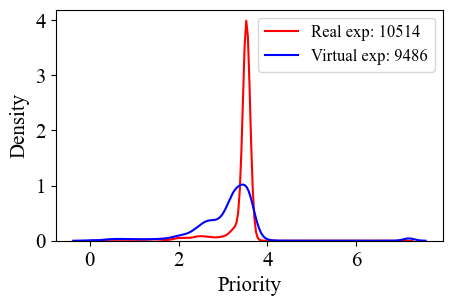

In [56]:
plt.figure(figsize=(5,3))
sns.kdeplot(data[data['type']==1]['priority'], color='r', label=f'Real exp: {sum(exp_type==0)}')
sns.kdeplot(data[data['type']==0]['priority'], color='blue', label=f'Virtual exp: {sum(exp_type==1)}')
plt.xlabel('Priority')
plt.ylabel('Density')
plt.legend(fontsize=12)
plt.savefig('C:/Users/Bowen/Desktop/repos/My_Papers/VAE based model/figures/sumo-sta-exp.pdf', bbox_inches='tight')

# Pool size